In [1]:
import numpy as np
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sqlite3

In [2]:
# Read all data
movies = pd.read_csv('data/tmdb_5000_movies.csv')
credits = pd.read_csv('data/tmdb_5000_credits.csv')

In [3]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [5]:
# Merging both the data
movies = movies.merge(credits, on='title')

In [6]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [7]:
# Taking usefull data and discarding the rest

movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

In [8]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [9]:
# Cleaning the database.
movies.dropna(inplace=True)
movies.isnull().sum()

movie_id    0
title       0
overview    0
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [10]:
# Cleaning the database with duplicate entry
movies.drop_duplicates(subset="title", keep="first", inplace=True)
movies = movies.reset_index(drop=True)
movies["title"].duplicated().sum()

0

In [11]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [12]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [13]:
# To convert genres column into list
def convertGenres(obj):
    genres = []
    for element in ast.literal_eval(obj):
        genres.append(element['name'].replace(" ","")) 
    return genres 

movies['genres'] = movies['genres'].apply(convertGenres)
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [14]:
movies.iloc[0].keywords

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [15]:
# To convert keywords column into list 
def convertKeywords(obj):
    keywords = []
    for element in ast.literal_eval(obj):
        keywords.append(element['name'].replace(" ",""))
         
    return keywords

movies['keywords'] = movies['keywords'].apply(convertKeywords)
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [16]:
# To convert cast column into list containing top 3 cast
def convertCast(obj):
    cast = []
    for element in ast.literal_eval(obj):
        cast.append(element['name'].replace(" ","")) 
        if len(cast) == 3 :
            break
    return cast

movies['cast'] = movies['cast'].apply(convertCast)
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [17]:
# To convert crew column into list containing director only
def convertCrew(obj):
    director = []
    for element in ast.literal_eval(obj):
        if element['job'] == 'Director':
            director.append(element['name'].replace(" ","")) 
            break
    return director

movies['crew'] = movies['crew'].apply(convertCrew)
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]


In [18]:
# To convert overview column into list of words
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]


In [19]:
# Combing all data under single column
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."


In [20]:
# Converting tags column to string
Movies_db = movies[['movie_id', 'title', 'tags']]
Movies_db['tags'] = Movies_db['tags'].apply(lambda x:" ".join(x))
Movies_db['tags'] = Movies_db['tags'].apply(lambda x:x.lower())
Movies_db

C:\Users\rahul\AppData\Local\Temp\ipykernel_14364\1241564872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movies_db['tags'] = Movies_db['tags'].apply(lambda x:" ".join(x))
C:\Users\rahul\AppData\Local\Temp\ipykernel_14364\1241564872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movies_db['tags'] = Movies_db['tags'].apply(lambda x:x.lower())


,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."
...,...,...,...
4792,9367,El Mariachi,el mariachi just wants to play his guitar and ...
4793,72766,Newlyweds,a newlywed couple's honeymoon is upended by th...
4794,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduces a dedic..."
4795,126186,Shanghai Calling,when ambitious new york attorney sam is sent t...


In [21]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Movies_db['tags'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index = Movies_db.index)
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,35294,35295,35296,35297,35298,35299,35300,35301,35302,35303
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


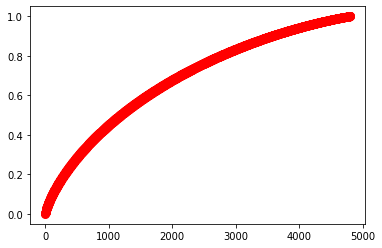

In [22]:
# Compress with SVD

svd = TruncatedSVD(n_components=5000)
latent_matrix = svd.fit_transform(tfidf_df)

# plot var to predicted how many latent dimension to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms=16, color='red')
plt.show()

In [23]:
# Number of Latent dimensions to keep
n = 5000
req_matrix = pd.DataFrame(latent_matrix[:,0:n], index=Movies_db.index)

In [24]:
req_matrix

,0,1,2,3,4,5,6,7,8,9,...,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796
0,0.093599,0.095826,0.128049,0.017102,0.011860,0.109963,-0.050272,0.025935,-0.075302,-0.003052,...,-0.005689,0.004877,-0.008129,-0.002203,0.014320,0.000396,-0.000755,-0.007227,-0.001144,0.000240
1,0.087993,0.039501,0.085700,0.002058,0.017434,0.020666,-0.055252,0.018633,-0.005737,0.073624,...,-0.010222,0.020911,-0.008359,0.019343,0.012977,-0.023962,0.001349,0.010489,0.017366,0.003642
2,0.087702,0.100267,0.004408,0.017245,0.037799,-0.007809,-0.016784,-0.021481,-0.000882,0.066884,...,-0.006601,-0.011887,0.002840,0.011675,-0.006171,0.012014,0.009044,0.012428,-0.006940,-0.001801
3,0.097207,0.089461,-0.033775,0.004975,0.046721,0.000875,-0.007501,0.037630,0.057230,0.000370,...,0.008778,0.003099,0.030680,0.016427,0.008353,0.008641,-0.011685,0.001399,0.000976,0.001709
4,0.089860,0.100361,0.114235,0.046377,-0.019746,0.063982,-0.012992,0.003583,-0.047465,-0.023683,...,0.003629,-0.003666,-0.001966,-0.003871,0.004062,0.008209,0.002184,-0.001215,0.001796,-0.004140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,0.089223,0.050926,-0.062783,-0.032696,0.018965,-0.045851,0.018446,0.001011,-0.001189,0.002395,...,-0.021781,-0.028440,-0.009432,-0.011222,0.017549,-0.031892,0.003800,0.016108,-0.012832,-0.004183
4793,0.044686,-0.056902,-0.001543,-0.005255,0.026334,0.041457,-0.026976,-0.022491,0.046633,-0.011915,...,0.004465,-0.004338,0.000551,-0.001255,0.000135,0.001433,0.003105,-0.005704,-0.000411,0.000175
4794,0.105805,-0.014892,0.011436,0.013200,0.003242,0.030421,-0.003266,-0.018308,-0.012399,-0.019805,...,0.003063,-0.002661,0.003829,-0.000628,0.000671,0.001619,-0.005286,-0.002703,-0.003257,-0.000556
4795,0.085693,-0.030804,-0.007661,-0.004341,0.022703,0.018664,-0.008473,0.019809,0.037204,-0.036787,...,0.001919,0.010584,0.000408,-0.005853,0.008054,0.004405,0.001540,-0.006980,0.005798,0.003227


In [25]:
similarity = cosine_similarity(req_matrix)
similarity

array([[ 1.00000000e+00,  1.46512987e-02,  7.85766100e-03, ...,
         3.23179671e-03,  3.49797653e-03,  6.48352899e-17],
       [ 1.46512987e-02,  1.00000000e+00,  8.79341140e-03, ...,
         1.13014066e-02, -7.26686506e-17, -8.19385792e-17],
       [ 7.85766100e-03,  8.79341140e-03,  1.00000000e+00, ...,
         1.02325739e-02, -4.48859699e-17,  1.18449087e-16],
       ...,
       [ 3.23179671e-03,  1.13014066e-02,  1.02325739e-02, ...,
         1.00000000e+00,  1.63772056e-02,  1.90594392e-02],
       [ 3.49797653e-03, -7.26686506e-17, -4.48859699e-17, ...,
         1.63772056e-02,  1.00000000e+00,  9.56156281e-03],
       [ 6.48352899e-17, -8.19385792e-17,  1.18449087e-16, ...,
         1.90594392e-02,  9.56156281e-03,  1.00000000e+00]])

In [26]:
def recommendedMovies(movie):
    movie_idx = Movies_db[Movies_db['title']==movie].index[0]
    distances = similarity[movie_idx]
    recommendation_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:20]
    
    return recommendation_list

In [27]:
def recommendMoviesOnHistory(history):
    recommendation_list = set()
    movie_id=[];
    req_per_Movie = 10/len(history) + 1
    
    for movie in history:
        for element in recommendedMovies(movie):
            count=0
            if Movies_db.iloc[element[0]]['title'] not in history:
                if element[0] not in movie_id:
                    count+=1;
                    movie_id.append(element[0])
                    recommendation_list.add(element)
                    if count == req_per_Movie:
                        break
                
    recommendation_list = sorted(recommendation_list,reverse=True, key=lambda x:x[1])[1:10]
    
    recommended_movies = [];
    for movie in recommendation_list:
        recommended_movies.append(Movies_db.iloc[movie[0]]['title'])
    
    return recommended_movies

In [28]:
history = ['The Dark Knight Rises']
recommendMoviesOnHistory(history)

['Batman Returns',
 'Batman Begins',
 'Batman Forever',
 'Batman',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman & Robin',
 'Batman v Superman: Dawn of Justice',
 'Slow Burn',
 'Defendor']

In [29]:
import io
import json
def adapt_array(arr):
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

conn = sqlite3.connect('movies_db1.sqlite3', detect_types=sqlite3.PARSE_DECLTYPES)
c = conn.cursor()
c.execute('DROP TABLE IF EXISTS movies')
c.execute('CREATE TABLE IF NOT EXISTS movies (movie_id number, title text)')
conn.commit()

(Movies_db[['movie_id', 'title']]).to_sql('movies', conn, if_exists='replace', index = True)

c.execute('DROP TABLE IF EXISTS recommended_movies')
c.execute('CREATE TABLE IF NOT EXISTS recommended_movies (id, recommended_id text)')

movie_idx=0
for movie in Movies_db['title']:
    distances = similarity[movie_idx]
    recommendation_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:6]
    rec_list=[]
    for id in recommendation_list: 
        rec_list.append((int(Movies_db.iloc[id[0]]["movie_id"]), id[1]))    
    c.execute('INSERT INTO recommended_movies (id ,recommended_id) values (?, ?)', (int(Movies_db.iloc[movie_idx]["movie_id"]), json.dumps(rec_list),))
    conn.commit()
    movie_idx+=1
    
